# Cropland vegetation condition anomalies

* **Products used:**
[ls8_sr](https://explorer.digitalearth.africa/ls8_sr), [ls7_sr](https://explorer.digitalearth.africa/ls7_sr), [crop_mask_eastern](https://explorer.digitalearth.africa/crop_mask_eastern)

## Background
Understanding how the vegetated landscape responds to longer-term environmental drivers such as the El Nino Southern Oscillation (ENSO) or climate change, requires the calculation of seasonal anomalies. Standardised seasonal anomalies subtract the long-term seasonal mean from a time-series and then divide the result by the long-term standard deviation, thus removing seasonal variability and highlighting change related to longer-term drivers.


### Description

This notebook will calculate seasonal standardised NDVI anomalies for any given season and year. The long-term seasonal climatologies (both mean and standard deviation) are calculated on-the-fly.


**Note:** It is a convention to establish climatologies based on a 30-year time range to account for inter-annual and inter-decadal modes of climate variability (often 1980-2010 or 1960-1990). As the landsat archive over Africa is patchy before 2000, the climatologies here have been calculated using the date-range 2000 - 2020 (inclusive). While this is not ideal, a 20-year climatology should suffice to capture the bulk of inter-annual and inter-decadal variability, for example, both a major El Nino (2015/16) and a major La Nina (2011) are captured by this time-range.

## Getting started
**To run this analysis**, run all the cells in the notebook, starting with the "Load packages" cell.

**After finishing the analysis**, return to the "Analysis parameters" cell, modify some values (e.g. choose a different location or time period to analyse) and re-run the analysis.

### Load packages
Load key Python packages and supporting functions for the analysis.

In [1]:
%matplotlib inline

import datacube
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, rgb, map_shapefile
from deafrica_tools.dask import create_local_dask_cluster

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Set up a Dask cluster

Dask can be used to better manage memory use down and conduct the analysis in parallel. 
For an introduction to using Dask with Digital Earth Africa, see the [Dask notebook](../Beginners_guide/08_Parallel_processing_with_dask.ipynb).

>**Note**: We recommend opening the Dask processing window to view the different computations that are being executed; to do this, see the *Dask dashboard in DE Africa* section of the [Dask notebook](../Beginners_guide/08_parallel_processing_with_dask.ipynb).

To use Dask, set up the local computing cluster using the cell below.

In [2]:
create_local_dask_cluster()

Client Scheduler: tcp://127.0.0.1:33623 Dashboard: /user/chad/proxy/8787/status,Cluster Workers: 1 Cores: 7 Memory: 63.57 GB


### Connect to the datacube
Activate the datacube database, which provides functionality for loading and displaying stored Earth observation data.

In [3]:
dc = datacube.Datacube(app="vegetation-condition")

### Analysis parameters

The following cell set important parameters for the analysis:

* `lat`: The central latitude to analyse (e.g. `14.283`).
* `lon`: The central longitude to analyse (e.g. `-16.921`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The date range over which the climatolgies will be calculated (e.g. `('2013', '2021') `)
* `year`: The year for which we will caluclate the standardised anomaly (must be within the climatology years)
* `season`: The season for which we will caluclate the standardised anomaly, e.g 'DJF','JFM', 'FMA' etc.

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example explores coastal change in Ponto, Senegal. 

**To run the notebook for a different area**, make sure Landsat data is available for the new location, which you can check at the [DE Africa Explorer](https://explorer.digitalearth.africa/) (use the drop-down menu to view all Landsat products).


In [4]:
# Define the area of interest
lat = 12.4917
lon = 37.7649
buffer = 0.1

# Set the range of dates for the climatology
time_range = ('2000', '2021')
year = '2020'
season = 'SON'
dask_chunks = dict(x=1500,y=1500)


# Combine central lat,lon with buffer to get area of interest
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [5]:
display_map(x=lon_range, y=lat_range)

## Define a function for filtering data to the season of interest

In [6]:
quarter = {'JFM': [1,2,3],
           'FMA': [2,3,4],
           'MAM': [3,4,5],
           'AMJ': [4,5,6],
           'MJJ': [5,6,7],
           'JJA': [6,7,8],
           'JAS': [7,8,9],
           'ASO': [8,9,10],
           'SON': [9,10,11],
           'OND': [10,11,12],
           'NDJ': [11,12,1],
           'DJF': [12,1,2]
          }

def filter_season(dataset):
    dss = []
    if dataset.time.begin.month in quarter[season]:
        dss.append(dataset)
    return dss

## Load cloud-masked Landsat data
The first step in this analysis is to load in Landsat data for the `lat_range`, `lon_range` and `time_range` we provided above. 
The code below uses the `load_ard` function to load in data from the Landsat 5, 7 and 8 satellites for the area and time specified.
For more infmation, see the [Using load_ard notebook](../Frequently_used_code/Using_load_ard.ipynb).
The function will also automatically mask out clouds from the dataset, allowing us to focus on pixels that contain useful data:

In [7]:
# Create the 'query' dictionary object, which contains the longitudes, 
# latitudes and time provided above
query = {
    'x': lon_range,
    'y': lat_range,
    'time': time_range,
    'measurements': ['red','nir'],
    'resolution': (-30, 30),
    'output_crs':'epsg:6933',
    'dask_chunks':dask_chunks
}

# Load available data Landsat 8
ds = load_ard(dc=dc, 
              products=['ls7_sr','ls8_sr'], 
              group_by='solar_day',
              predicate=filter_season,
              **query)


Using pixel quality parameters for USGS Collection 2
Finding datasets
    ls7_sr
    ls8_sr
Filtering datasets using filter function
Applying pixel quality/cloud mask
Re-scaling Landsat C2 data
Returning 274 time steps as a dask array


## Calculate NDVI climatologies

In [8]:
#calculate NDVI
ndvi = calculate_indices(ds, 'NDVI', collection='c2', drop=True)

#clalculate the climatologies
climatology_mean = ndvi.mean("time").NDVI.compute()
climatology_std = ndvi.std("time").NDVI.compute()

Dropping bands ['red', 'nir']


## Calculate standardised anomalies

First calculate the mean NDVI over the year and season we're interested in

In [9]:
seasonal_mean = ndvi.sel(time=year).mean('time').NDVI.compute()

Now we can calculate the standardised anmalies by subtracting the long-term mean and dividing by the long-term standard deviation

In [10]:
stand_anomalies = xr.apply_ufunc(
    lambda x, m, s: (x - m) / s,
    seasonal_mean,
    climatology_mean,
    climatology_std,
    output_dtypes=[ds.red.dtype],
    dask="allowed"
)

### Plot the results of all the components of the calculation

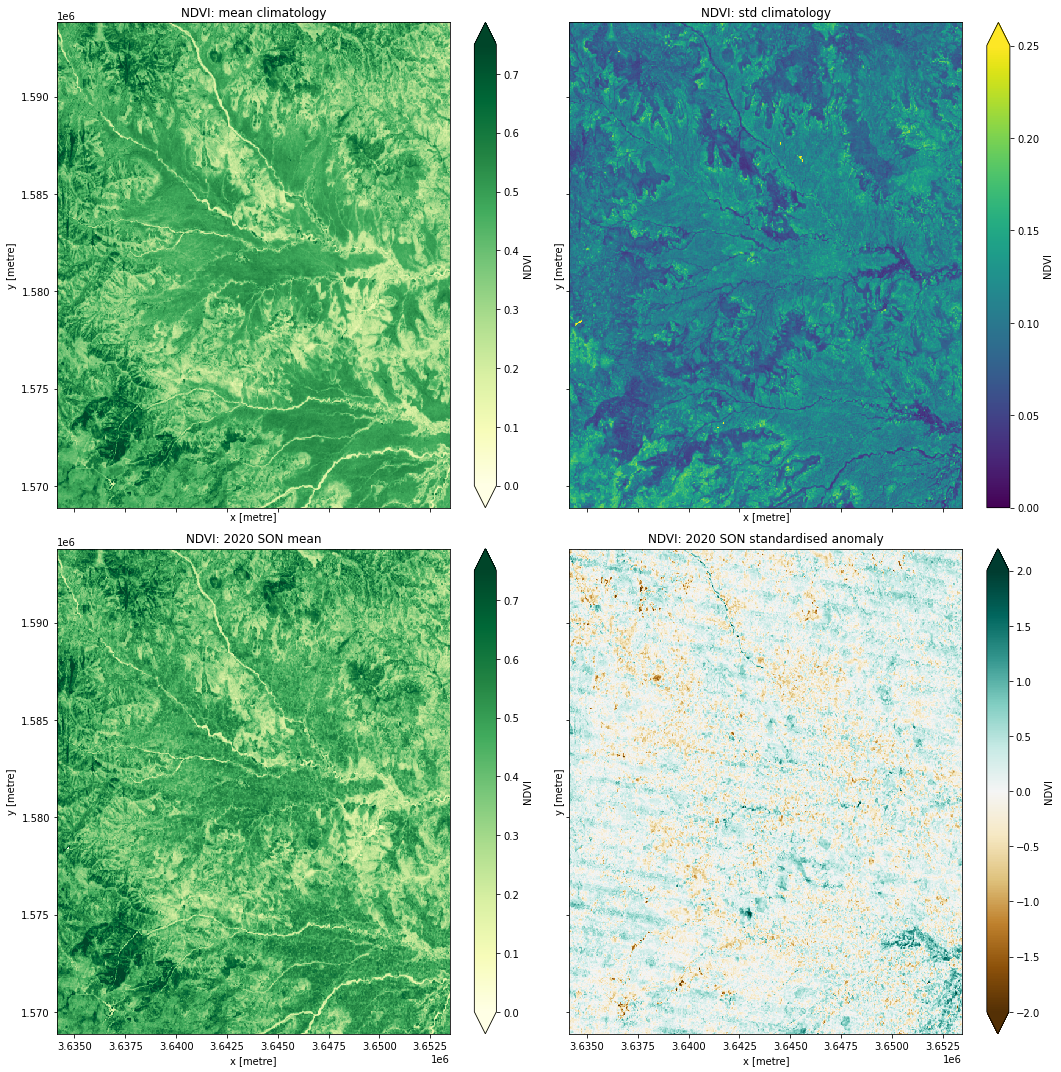

In [23]:
fig,ax = plt.subplots(2,2, sharey=True, sharex=True, figsize=(15,15))

climatology_mean.plot.imshow(ax=ax[0,0], cmap='YlGn' ,vmin=0, vmax=0.75)
ax[0,0].set_title('NDVI: mean climatology')
climatology_std.plot.imshow(ax=ax[0,1], vmin=0, vmax=0.25)
ax[0,1].set_title('NDVI: std climatology')
seasonal_mean.plot.imshow(ax=ax[1,0], cmap='YlGn', vmin=0, vmax=0.75)
ax[1,0].set_title('NDVI: '+year+" "+season+' mean')
stand_anomalies.plot.imshow(ax=ax[1,1], cmap='BrBG',vmin=-2, vmax=2)
ax[1,1].set_title('NDVI: '+year+" "+season+' standardised anomaly')
plt.tight_layout();

## Incorporating DE Africa's Cropland Extent Map

Load the crop over the region of interest

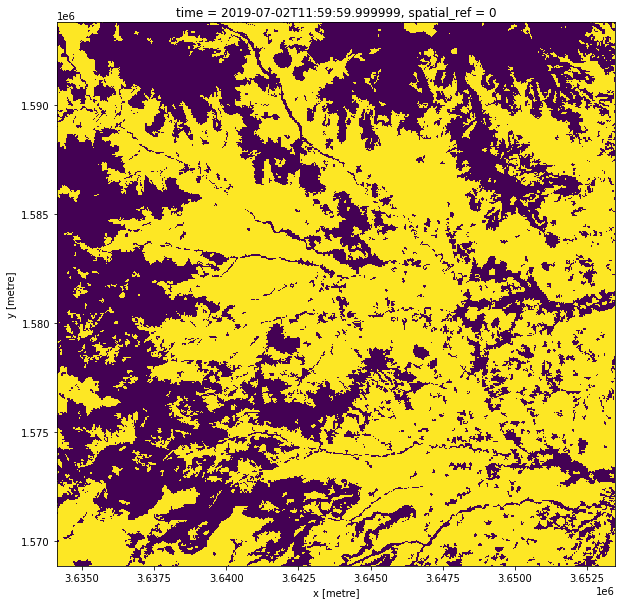

In [16]:
cm = dc.load(product='crop_mask_eastern',
            time=('2019'),
            measurements='filtered',
            resampling='nearest', 
            like=ds.geobox).filtered.squeeze()

cm.plot.imshow(add_colorbar=False, figsize=(10,10));

### Plot anomalies for croppped regions

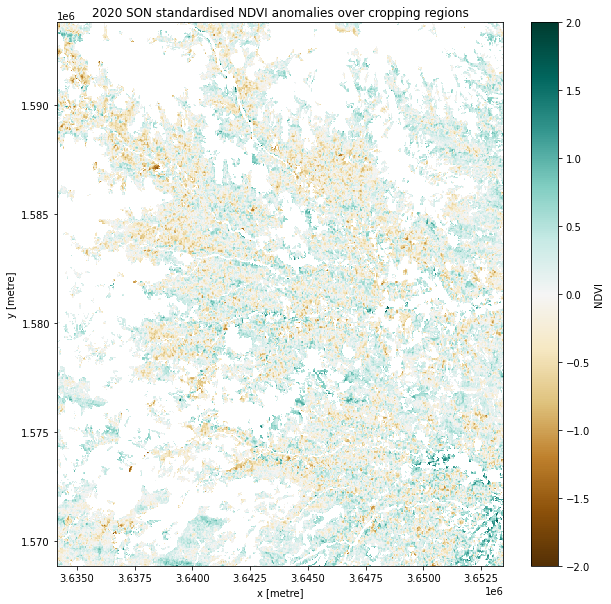

In [22]:
fig,ax = plt.subplots(1,1, sharey=True, figsize=(10,10))

stand_anomalies.where(cm).plot.imshow(ax=ax, cmap='BrBG',vmin=-2, vmax=2)
ax.set_title(year+" "+season+' standardised NDVI anomalies over cropping regions');

# stand_anomalies.where(cm==0).plot.imshow(ax=ax[1], cmap='BrBG',vmin=-2, vmax=2)
# ax[1].set_title(year+" "+season+' standardised NDVI anomalies over non-cropping regions')
# plt.tight_layout();

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [14]:
print(datacube.__version__)

1.8.4.dev193+g3997b90f


**Last Tested:**

In [15]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-08-06'